# Mining & Modelling Character Networks

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from pylab import rcParams
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from collections import defaultdict
sns.set()

Paper Reference [Here](https://math.ryerson.ca/~abonato/papers/CharacterNetworks_WAW_Aug1_BDAEGH.pdf)

In [2]:
# constants
names_df_path = './data/ontario_names_list_1917-2019.csv'
stop = stopwords.words('english')
additional_sw = [
    'well', 'would', 'never', 'latitude', 'longitude', 'wonderland', 'wonder', 'adventure', 'adventures', 'chapter',
    'please', 'maam', 'drink', 'think', 'sink', 'come', 'foot', 'right', 'thats', 'too', 'itll', 'tell', 'table', 'long',
    'tale', 'test', 'said', 'held', 'crab', 'next', 'sure', 'digging', 'i', 'i\'ve', 'oh', 'bills',
    'number', 'ill', 'im', 'ive', 'whats', 'read', 'little', 'id',    'look', 'dont', 'luckily', 'get', 'lizard', 'the'
]

## Mine Character Names

- https://medium.com/agatha-codes/using-textual-analysis-to-quantify-a-cast-of-characters-4f3baecdb5c
- https://www.gutenberg.org/  -- Free eBook Data Source
- https://home.aveek.io/blog/post/finding-main-characters/

## Import Data

In [3]:
# to download books data
# nltk.download('gutenberg')
book = nltk.corpus.gutenberg.raw('carroll-alice.txt')

## Clean Data

In [4]:
def remove_punctuations(txt, punct = string.punctuation):
    '''
    This function will remove punctuations from the input text
    '''
    return ''.join([c for c in txt if c not in punct])

In [5]:
def remove_stopwords(txt, sw = list(stopwords.words('english')) + additional_sw):
    '''
    This function will remove the stopwords from the input txt
    '''
    return ' '.join([w for w in txt.split() if w.lower() not in sw])

In [6]:
def clean_text(txt):
    '''
    This function will clean the text being passed by removing specific line feed characters
    like '\n', '\r', and '\'
    '''
    
    txt = txt.replace('\n', ' ').replace('\r', ' ').replace('\'', '')
    txt = remove_punctuations(txt)
    txt = remove_stopwords(txt)
    return txt.lower()

In [7]:
%%time
book= clean_text(book) 

CPU times: user 49 ms, sys: 1.28 ms, total: 50.3 ms
Wall time: 49.8 ms


## Identify Characters

There are various ways to identify character names. Here I'll go over 2 similar approaches to identifying character names in a body of text. The first is a regex which finds the names of characters, the second is to use a list of known names in the english language and cross reference those known names with the body of text to identify which known names are also found in this body of text. The second approach can be done using two different sources : 
1) NLTK Names Corpus - A corpus of male and female names curated by NLTK
2) Ontario Baby Names 1917-2019 - A corpus of male and female names provided by the government of Ontario

Overall, let me caveat this section by stating the obvious, none of these approaches will yield 100% accurate results for any given body of text. Even trying out NLP solutions in NER won't give too strong solutions as it's difficult for a machine / algorithm to identify aliases, groups, and other nuances which only a human can pick up. The best approach is for the user to create a dictionary where the keys are the known names in the body of text and the values are a list of aliases associated to that known name. For example in Harry Potter, the known dictionary would look something like this : 

```python
known_dct = {
    'Harry' : ['Harry Potter', 'The Chosen One', ...],
    'Voldemort' : ['He Who Must Not Be Named', 'Voldything', ...],
    ...
}
```

In [8]:
# def find_names(text, given_names, names):
#     '''
#     Given the list of male and female names from the NLTK library, this function will
#     parse through the input text and identify a list of names found in the input text
#     by cross referencing it with the NLTK names.
#     '''
    
#     text = text.split(' ')
#     for name in names:
#         if name in text and name not in given_names:
#             given_names.append(name)
#     return given_names

In [9]:
def find_names(text, given_names, names):
    '''
    Given a body of text, this function will identify the names in that body of text
    by cross referencing list of names in the body of text
    
    params:
        text (String) : A body of text you want to parse through to identify names
        given_names (List / Dict) : The list / dictionary of known names in the body of 
                                    text, if the input is a dictionary, the keys are the
                                    main names and the values are a list of aliases
        names (List) : A corpus of names recorded throughout the world
        
    returns:
        This function will return an updated given_names which holds the user input as 
        well as other names which the algorithm has found
    '''
    text = text.lower().split(' ')
    given_names_copy = given_names
    kn = []
    if type(given_names) == dict:
        for k,v in given_names_copy.items():
            if k not in v:
                given_names_copy[k].append(k)
        for k,v in given_names_copy.items():
            for name in v:
                kn.append(name)
    elif type(given_names) == list:
        for name in names:
            if name in text and name not in given_names:
                given_names.append(name)
        return given_names
        
    for name in names:
        if name in text and name not in kn:
            given_names_copy[name] = []
    return given_names_copy

### Approach 1 : Regex

In [10]:
# source : https://stackoverflow.com/questions/55194224/extract-names-from-string-with-python-regex
# sol 1 
TITLE = r"(?:[A-Z][a-z]*\.\s*)?"
NAME1 = r"[A-Z][a-z]+,?\s+"
MIDDLE_I = r"(?:[A-Z][a-z]*\.?\s*)?"
NAME2 = r"[A-Z][a-z]+"

sol1 = list(set(re.findall(TITLE + NAME1 + MIDDLE_I + NAME2, book)))

# sol 2 
regex = re.compile(r'([A-Z][a-z]+(?: [A-Z][a-z]\.)? [A-Z][a-z]+)')
sol2 = list(set(regex.findall(book)))

print(len(sol1), len(sol2))

0 0


### Approach 2 : NLTK Names Corpus

In [11]:
from nltk.corpus import names
nltk.download('names')
print("\nNumber of male names:")
print (len(names.words('male.txt')))
print("\nNumber of female names:")
print (len(names.words('female.txt')))
male_names = names.words('male.txt')
female_names = names.words('female.txt')


Number of male names:
2943

Number of female names:
5001


[nltk_data] Downloading package names to
[nltk_data]     /Users/vatsalpatel/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [12]:
male_names = [x.lower() for x in male_names]
female_names = [x.lower() for x in female_names]

In [13]:
%time found_names = find_names(book, given_names = [], names = male_names + female_names)

CPU times: user 979 ms, sys: 5.96 ms, total: 985 ms
Wall time: 991 ms


### Approach 3 : Government Names List

In [14]:
# male names source : https://data.ontario.ca/dataset/ontario-top-baby-names-male
# female names source : https://data.ontario.ca/dataset/ontario-top-baby-names-female

In [15]:
# male_names = pd.read_csv(
#     'https://raw.githubusercontent.com/SMG-Digital/tads_age_model/Master/data/csv/ontario_top_baby_names_male_1917-2019_en_fr.csv?token=AUH4CTU4EBSNMV2GPMM4PODB3FC4G'
# )

# female_names = pd.read_csv(
#     'https://raw.githubusercontent.com/SMG-Digital/tads_age_model/Master/data/csv/ontario_top_baby_names_female_1917-2019_en_fr.csv?token=AUH4CTRCD7TDGPSVDUB7JKLB3FDBW'
# )

# names_df = pd.concat([male_names, female_names])
# names_df['name'] = names_df['name'].apply(lambda x : str(x).lower())
# drop_names = [
#     'none', 'real', 'baby', 'new', 'rock', 'harm', 'ever', 'patience', 'tea', 'winter', 'journey', 'else', 'gay', 
#     'shant', 'hung', 'line'
# ]
# remove = names_df[names_df['name'].isin(drop_names)].index
# names_df[~names_df.index.isin(remove)].to_csv('./data/ontario_names_list_1917-2019.csv', index = False)

In [16]:
names_df = pd.read_csv(
    names_df_path
)
names_df.shape

(164034, 4)

In [17]:
names_list = list(names_df['name'].values)

In [18]:
known_names = {
    'alice' : [],
    'white rabbit' : ['rabbit'],
    'mouse' : [],
    'dodo' : [],
    'lory' : [],
    'eaglet' : [],
    'duck' : [],
    'pat' : [],
    'bill the lizzard' : ['bill', 'lizard'],
    'puppy' : [],
    'caterpillar' : [],
    'duchess' : [],
    'cheshire cat' : ['cat', 'cheshire'],
    'hatter' : [],
    'march hare' : ['hare', 'march'],
    'dormouse' : [],
    'queen of hearts' : ['queen'],
    'king of hearts' : ['king'],
    'knave of hearts' : ['knave'],
    'gryphon' : [],
    'mock turtle' : ['turtle'],
    'two' : [],
    'five' : [],
    'seven' : []
}

In [19]:
%%time
kn = [
    'alice', 'rabbit', 'queen', 'king', 'cat', 'Duchess', 'caterpillar', 'hatter', 'hare', 'dormouse', 'gryphon',
    'turtle', 'sister', 'knave', 'mouse', 'dodo', 'cook', 'duck', 'pigeon', 'two', 'five', 'seven', 'bill', 'frog'
]
found_names_lst = find_names(book, given_names = kn, names = names_list)

CPU times: user 19.6 s, sys: 63 ms, total: 19.7 s
Wall time: 19.7 s


In [20]:
%%time 
found_names_dct = find_names(book, given_names = known_names, names = names_list)

CPU times: user 19.8 s, sys: 76.7 ms, total: 19.9 s
Wall time: 20.2 s


In [21]:
print(len(found_names_lst), len(found_names_dct.keys()))
print(found_names_lst)

73 71
['alice', 'rabbit', 'queen', 'king', 'cat', 'Duchess', 'caterpillar', 'hatter', 'hare', 'dormouse', 'gryphon', 'turtle', 'sister', 'knave', 'mouse', 'dodo', 'cook', 'duck', 'pigeon', 'two', 'five', 'seven', 'bill', 'frog', 'edgar', 'edwin', 'grant', 'lewis', 'mark', 'royal', 'william', 'carroll', 'miles', 'mary', 'boy', 'drew', 'pat', 'chance', 'sang', 'man', 'justice', 'raven', 'sage', 'deep', 'tie', 'sky', 'london', 'young', 'case', 'grey', 'nile', 'bear', 'shepherd', 'ada', 'ann', 'elsie', 'mabel', 'may', 'rose', 'tillie', 'hope', 'dinah', 'france', 'girl', 'velvet', 'lory', 'summer', 'lacie', 'paris', 'precious', 'pepper', 'lark', 'majesty']


Other sources of mining character names were also explored like using NER, the reason I didn't go forward in showing this was because only the high end solutions yielded any useful results. Through small scale solutions like using the built in NER models in NLTK and Spacy, we ended up with too many false positives, although the results above will also yield false positives, they won't be of the magnitude of the NER solutions. The one solution through NER which did yield useful results was from training BERT on labelled named data on this corpus of text. However, although this yielded good accuracy, it was also very expensive in both time and money. I didn't have the time or resources to label thousands of books on name data and retrain the BERT model, nor did I have lot's of money to allocate towards GPUs to aid the training process. Thus the simple approach of finding names was the one I show cased right now.

## Find Character Interactions

This section is determined by the way you define character interactions. From part 1 of this series, we found that there are many ways to identify character interactions. From Labatut and Bost, they highlighted 6 different approaches for identifying interaction between characters [2], namely,  
1) Co-occurrence of characters
2) Direct verbal interactions between characters
3) Explicit mentioning between characters
4) Non verbal interactions (fighting, kissing, killing, etc.)
5) Affiliation between characters (coworkers, family, friends, etc.)
6) Hybrid approaches of 1–5  

For the purposes of this article, we will focus on the first approach of character interaction, the co-occurences of characters. We can define that two characters have a co-occurance if their names are stated between an N period of words. The value for N can be determined by the user, in "Mining and Modelling Character Networks" by Bonato et al. they chose their N to be equal to 15. We can use the same value of N for our purposes.

In [22]:
N = 15
text = book
found_names = found_names_dct

In [23]:
def lower_known_names_dct(known_names):
    '''
    The purpose of this function is to add the key into the list of values
    as a lowered key
    '''
    if type(known_names) == list:
        known_names = {k:[k] for k in known_names}
        
    known_names_full = known_names.copy()
    for k,v in known_names_full.items():
        if k.lower not in v:
            v.append(k.lower())
    return known_names_full

found_names_full = lower_known_names_dct(known_names)

In [24]:
def generate_idx_dict(text, found_names_full):
    '''
    create an idx_dct where the keys are the idx of the names in
    the text and the values are the names
    '''
    res = dict()
    for i,word in enumerate(text.lower().split(' ')):
        for k,v in found_names_full.items():
            if word not in v:
                continue
            res[i] = k
    return res
idx_dct = generate_idx_dict(text, found_names_full)

In [25]:
def find_interactions(idx_dct, N):
    res = defaultdict(int)
    names = list(idx_dct.keys())
    
    for i,na in enumerate(names):
        # given an index, get the sublist of all indicies greater than the current index
        if i < len(names) - 1:
            kl = names[i+1:]
        else:
            kl = []
        
        # for each idx greater than the current, check if its found in the range of N
        for k in kl:
            if k-na < N:
                # get names found in current position (na) and index greater than current but in rnage N (k)
                n1 = idx_dct[na]
                n2 = idx_dct[k]
                
                key = tuple(sorted([n1,n2]))
                res[key]+=1
    return res

In [26]:
interactions_dct = find_interactions(idx_dct, N)

In [27]:
interactions_lst = list([(*k,v) for (k,v) in interactions_dct.items()])

## Creating Character Network

For this, we'll create a weighted network. The nodes will be the characters themselves and the edges will be formed from the co-occurences we've found above. The weight of the edges will be determined by the frequency of co-occurences in the given body of text. For example, if Alice and the Queen had 15 interactions in the body of text, the weight associated to the edge connecting Alice to the Queen would be 15.

In [28]:
edges_df = pd.DataFrame(interactions_lst, columns = ['source', 'target', 'weight'])

In [29]:
G = nx.from_pandas_edgelist(edges_df, edge_attr = True)

In [30]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 289
Average degree:   8.5000


In [31]:
G['alice']['white rabbit']

{'weight': 38}

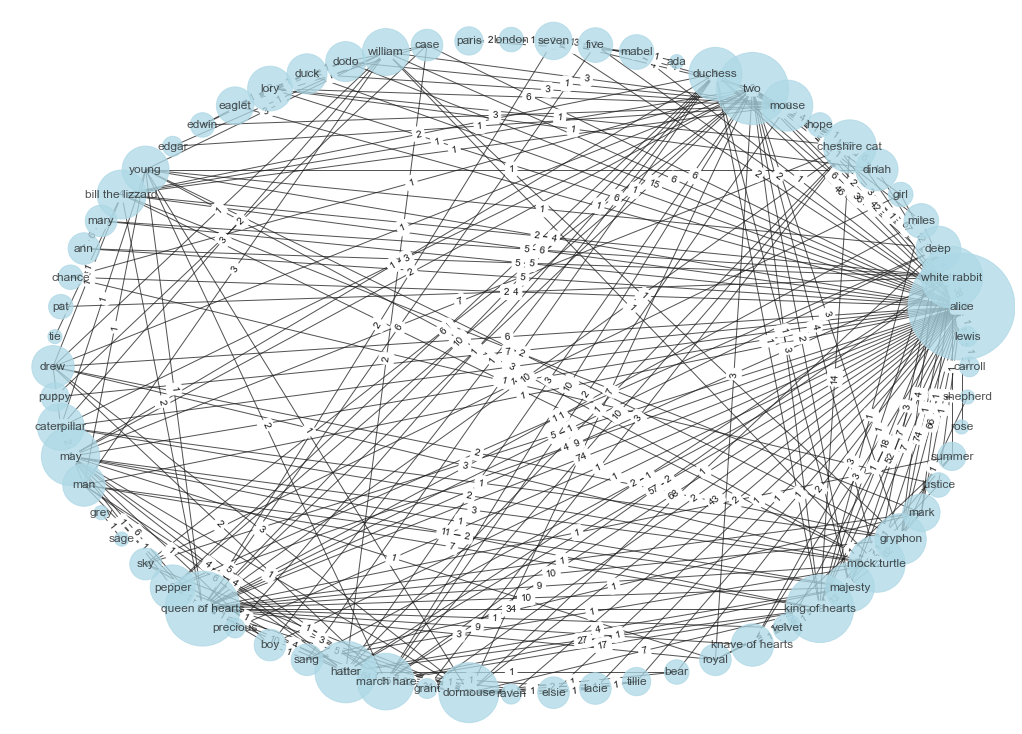

In [32]:
rcParams['figure.figsize'] = 14, 10
pos = nx.circular_layout(G, scale = 20)
labels = nx.get_edge_attributes(G, 'weight')
# pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
nx.draw(
    G, 
    pos,
    node_color='lightblue', 
    alpha = 0.75,
    with_labels=True, 
    nodelist=d, 
    node_size=[d[k]*200 for k in d],
    edgelist = labels
)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

### Visualize Page Rank for Character Importance

In [33]:
pr = nx.pagerank(G)
pr = {k: v for k, v in sorted(pr.items(), reverse = True, key=lambda item: item[1])}
pr_df = pd.DataFrame([pr]).T.reset_index().rename(columns = {0 : 'pr', 'index' : 'name'})

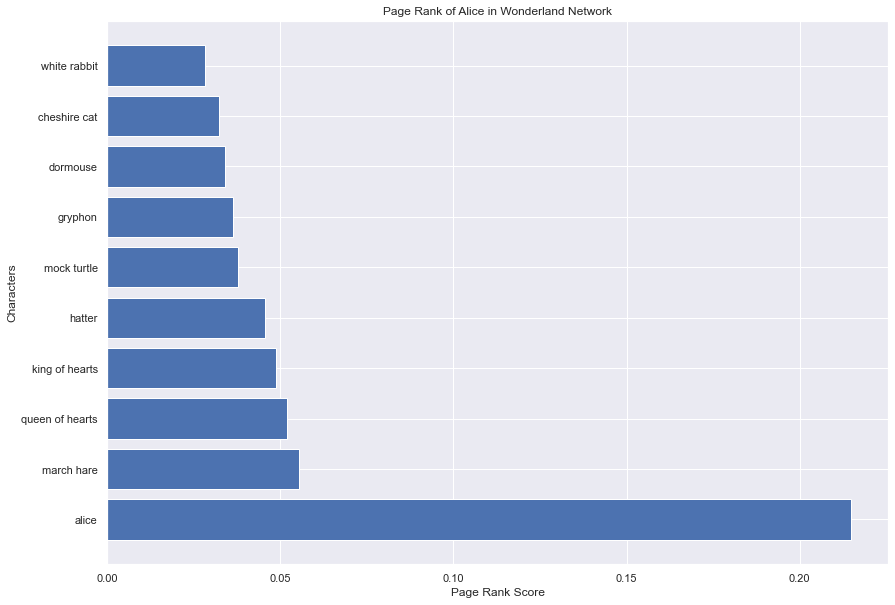

In [34]:
plt.barh(y = pr_df['name'].head(10), width = pr_df['pr'].head(10))
plt.title("Page Rank of Alice in Wonderland Network")
plt.ylabel("Characters")
plt.xlabel("Page Rank Score")
plt.show()

## Chung Lu Model

Based on the paper written by Bonato et al. the Chung-Lu model was the best performing model in capturing the results of original character network, hence we will implement the model here. The model is outlined by the paper (Generating large scale-free networks with the Chung-Lu random graph model by Dario Fasino, Arianna Tonetto and Francesco Tudisco)[https://arxiv.org/pdf/1910.11341.pdf], they have made the Python and MATLAB source code associated to the model open source via their (Github Repository)[https://github.com/ftudisco/scalefreechunglu]. We can just do some slight refactoring for the input parameters to match the degree distribution of our network. 

In [35]:
# source : https://github.com/ftudisco/scalefreechunglu/blob/master/python/fastchunglu.py
# The two functions below generate an instance of the Chung-Lu random graph model with expected degree sequence w

def make_sparse_adj_matrix(w):
    '''
    This function creates a sparse adjacency matrix of the input vector w
    
    params:
        w (List) :  A vector of nonnegative real numbers which define the model
    
    returns:
        It will return a scipy.sparse adjacency matrix of the graph
    '''
    # Outputs the scipy.sparse adjacency matrix of the graph
    n = np.size(w)
    s = np.sum(w)
    m = ( np.dot(w,w)/s )**2 + s
    m = int(m/2)
    wsum = np.cumsum(w)
    wsum = np.insert(wsum,0,0)
    wsum = wsum / wsum[-1]
    I = np.digitize(np.random.rand(m,1),wsum)
    J = np.digitize(np.random.rand(m,1),wsum)
    row_ind = np.append(I.reshape(m,)-1,J.reshape(m,)-1)
    col_ind = np.append(J.reshape(m,1)-1,I.reshape(m,)-1)
    ones = [1 for i in range(2*m)]    
    A = csr_matrix((ones, (row_ind,col_ind)), shape=(n,n))
    A.data.fill(1)
    return A


def make_nx_graph(w):
    '''
    This function will create a networkx graph from the input vector w
    
    params:
        w (List) :  A vector of nonnegative real numbers which define the model
    
    returns:
        It will return a nx.Graph of the graph
    '''
    n = np.size(w)
    s = np.sum(w)
    m = ( np.dot(w,w)/s )**2 + s
    m = int(m/2)
    wsum = np.cumsum(w)
    wsum = np.insert(wsum,0,0)
    wsum = wsum / wsum[-1]
    I = np.digitize(np.random.rand(m,1),wsum)
    J = np.digitize(np.random.rand(m,1),wsum)
    G = nx.Graph()
    G.add_nodes_from(range(1,n+1))
    G.add_edges_from(tuple(zip(I.reshape(m,),J.reshape(m,))))
    return G

In [36]:
degrees = [x[1] for x in list(G.degree(weight='weight'))]
avg_deg = sum(degrees) / float(len(G))

In [37]:
n = len(G.nodes())
gamma = 10       # power law distribution exponent
m = max(degrees)  # max degree
d = avg_deg   # avg degree
p = 1/(gamma-1)
c = (1-p)*d*(n**p)
i0 = (c/m)**(1/p) - 1
w = [c/((i+i0)**p) for i in range(1, n+1)]

In [38]:
%time A = make_sparse_adj_matrix(w)

CPU times: user 25.2 ms, sys: 2.33 ms, total: 27.5 ms
Wall time: 31.1 ms


In [39]:
%time G_cl = make_nx_graph(w)

CPU times: user 69.3 ms, sys: 1.66 ms, total: 71 ms
Wall time: 70.3 ms


In [40]:
print(nx.info(G_cl))

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 2346
Average degree:  69.0000


In [41]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 289
Average degree:   8.5000


In [42]:
print(nx.info(nx.expected_degree_graph(w)))

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 1766
Average degree:  51.9412
